# Optimizing Prepaid Plans: A Revenue Analysis for Megaline Telecom

# Project Objective

This data science project aims to provide Megaline with the insights required to identify the prepaid plan, either Surf or Ultimate, that generates higher revenue. By analyzing the behavior of 500 selected Megaline clients, this analysis will unveil patterns and trends necessary for informed decisions regarding plan promotion and adjustments. The project involves data exploration and cleaning, including the identification of missing values, duplicates, and inconsistencies. Statistical analysis and data visualizations will offer insights into client behavior, monthly usage, call duration, and other relevant characteristics. Utilizing statistical tests, we will assess the significant differences in revenue between Surf and Ultimate plans. Additionally, predictive models will be developed to estimate the potential revenue generated by promoting one plan over the other.

Ultimately, our goal is to empower Megaline's commercial department to make data-driven decisions to optimize their advertising budget and prepaid plan offerings.

## Description of the plans

**Note:** Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

**Surf Plan**
- Monthly charge: $20
- 500 monthly minutes, 50 texts, and 15 GB of data

 *After exceeding the package limits:*
- 1 minute: 3 cents
- 1 text message: 3 cents
- 1 GB of data: $10

**Ultimate Plan**
- Monthly charge: $70
- 3000 monthly minutes, 1000 text messages, and 30 GB of data

*After exceeding the package limits:*
- 1 minute: 1 cent
- 1 text message: 1 cent
- 1 GB of data: $7

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import math
import seaborn as sns

## Load data

In [2]:
# Load the data files into DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')


## Data Preprocesssing

## Plans

In [ ]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [ ]:
# Print a sample of data for plans
print(plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


The above printed data breaks down the Suf and Ultimate plan packages. This data has no issues.

## Users

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [ ]:
# Print a sample of data for users
print(users.head())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  


The users DataFrame should be altered to change the reg_date and churn_date columns from objects to datetime. There are NaN values in the churn_date for users who have not canceled their plans. The city column can be split into 2 columns, for city and state, while also removing the dashes in city names. 

### Fix Data

In [ ]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['city'] = users['city'].str.replace('-', '_')
users.fillna(value=0, inplace=True)

print(users.info())
print(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB
None
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta_Sandy Springs_Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle_Tacoma_Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas_Henderson_Paradise, NV MSA   
3     1003   Reynaldo

### Enrich Data

In [ ]:
users['state'] = users['city'].str.split(', ').str[-1]
users['city'] = users['city'].str.split(', ').str[0]

print(users.head())

   user_id first_name  last_name  age                           city  \
0     1000   Anamaria      Bauer   45  Atlanta_Sandy Springs_Roswell   
1     1001     Mickey  Wilkerson   28        Seattle_Tacoma_Bellevue   
2     1002     Carlee    Hoffman   36   Las Vegas_Henderson_Paradise   
3     1003   Reynaldo    Jenkins   52                          Tulsa   
4     1004    Leonila   Thompson   40        Seattle_Tacoma_Bellevue   

    reg_date      plan churn_date   state  
0 2018-12-24  ultimate          0  GA MSA  
1 2018-08-13      surf          0  WA MSA  
2 2018-10-21      surf          0  NV MSA  
3 2018-01-28      surf          0  OK MSA  
4 2018-05-23      surf          0  WA MSA  


## Calls

In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


In [ ]:
# Print a sample of data for calls
print(calls.head())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


The calls DataFrame should change call_date from object to datetime. There are no missing values or other issues. We can also change id to calls_id since there are multiple DataFrames with the id column. The project description requires that the duration in minutes be rounded up, values with 0, are rounded up to 1.

### Fix data

In [ ]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls.fillna(value=0, inplace=True)

print(calls.isnull().sum())
print(calls.duplicated().sum())

id           0
user_id      0
call_date    0
duration     0
dtype: int64
0


### Enrich data

In [ ]:
calls = calls.rename(columns={'id': 'call_id'})
calls['duration'] = np.ceil(calls['duration'])
print(calls.info())
print(calls.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   call_id    137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
None
    call_id  user_id  call_date  duration
0   1000_93     1000 2018-12-27       9.0
1  1000_145     1000 2018-12-27      14.0
2  1000_247     1000 2018-12-27      15.0
3  1000_309     1000 2018-12-28       6.0
4  1000_380     1000 2018-12-30       5.0


## Messages

In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


In [ ]:
# Print a sample of data for messages
print(messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


The calls DataFrame has 76051 entries. should change message_date from object to datetime, and specify id, as messages_id. 

### Fix data

In [ ]:
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages.fillna(value=0, inplace=True)

### Enrich data

In [ ]:
messages = messages.rename(columns={'id': 'message_id'})

## Internet

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


In [ ]:
# Print a sample of data for the internet traffic
print(internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


The internet DataFrame has 104824 entries and includes columns; id, user_id, session_date, and mb_used. The session_date type should be changed from object to datetime.  The total mb_used for the month is rounded up. If someone uses 1025 megabytes, they will be charged for 2 gigabytes, as per noted in the project description.

### Fix data

In [ ]:
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet.fillna(value=0, inplace=True)
internet.rename(columns={'session_month': 'month'}, inplace=True)
print(internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


### Enrich data

In [ ]:
internet = internet.rename(columns={'id': 'internet_id'})
internet['month'] = pd.to_datetime(internet['session_date']).dt.month
internet = internet.rename(columns={'id': 'internet_id'})
total_per_user_month = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet = pd.merge(internet, total_per_user_month[['user_id', 'month', 'mb_used']], on=['user_id', 'month'])

print(internet.head(10))

  internet_id  user_id session_date  mb_used_x  month  mb_used_y
0     1000_13     1000   2018-12-29      89.86     12    1901.47
1    1000_204     1000   2018-12-31       0.00     12    1901.47
2    1000_379     1000   2018-12-28     660.40     12    1901.47
3    1000_413     1000   2018-12-26     270.99     12    1901.47
4    1000_442     1000   2018-12-27     880.22     12    1901.47
5      1001_0     1001   2018-08-24     284.68      8    6919.15
6     1001_90     1001   2018-08-29     499.76      8    6919.15
7     1001_97     1001   2018-08-27     106.97      8    6919.15
8    1001_102     1001   2018-08-18     479.78      8    6919.15
9    1001_108     1001   2018-08-16      82.78      8    6919.15


## Plan Conditions

In [ ]:
for index, plan in plans.iterrows():
    print("Plan Name:", plan["plan_name"])
    print("Messages included:", plan["messages_included"])
    print("MB per month included:", plan["mb_per_month_included"])
    print("Minutes included:", plan["minutes_included"])
    print("USD monthly pay:", plan["usd_monthly_pay"])
    print("USD per GB:", plan["usd_per_gb"])
    print("USD per message:", plan["usd_per_message"])
    print("USD per minute:", plan["usd_per_minute"])


Plan Name: surf
Messages included: 50
MB per month included: 15360
Minutes included: 500
USD monthly pay: 20
USD per GB: 10
USD per message: 0.03
USD per minute: 0.03
Plan Name: ultimate
Messages included: 1000
MB per month included: 30720
Minutes included: 3000
USD monthly pay: 70
USD per GB: 7
USD per message: 0.01
USD per minute: 0.01


## Aggregate data per user

In [ ]:
# Calculate the number of calls made by each user per month
calls['month'] = pd.to_datetime(calls['call_date']).dt.to_period('M')
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls_made=('call_id', 'nunique'), minutes_spent=('duration', 'sum')).reset_index()
print(calls_per_month)


      user_id    month  calls_made  minutes_spent
0        1000  2018-12          16          124.0
1        1001  2018-08          27          182.0
2        1001  2018-09          49          315.0
3        1001  2018-10          65          393.0
4        1001  2018-11          64          426.0
...       ...      ...         ...            ...
2253     1498  2018-12          39          339.0
2254     1499  2018-09          41          346.0
2255     1499  2018-10          53          385.0
2256     1499  2018-11          45          308.0
2257     1499  2018-12          65          496.0

[2258 rows x 4 columns]


In [ ]:
# Calculate the amount of minutes spent by each user per month. Save the result.
calls['month'] = pd.to_datetime(calls['call_date']).dt.to_period('M')
minutes_per_user_month = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
minutes_per_user_month = minutes_per_user_month.rename(columns={'duration': 'minutes_spent'})
print(minutes_per_user_month)

      user_id    month  minutes_spent
0        1000  2018-12          124.0
1        1001  2018-08          182.0
2        1001  2018-09          315.0
3        1001  2018-10          393.0
4        1001  2018-11          426.0
...       ...      ...            ...
2253     1498  2018-12          339.0
2254     1499  2018-09          346.0
2255     1499  2018-10          385.0
2256     1499  2018-11          308.0
2257     1499  2018-12          496.0

[2258 rows x 3 columns]


In [ ]:
# Calculate the number of messages sent by each user per month. Save the result.
messages['month'] = pd.to_datetime(messages['message_date']).dt.to_period('M')
messages_per_user_month = messages.groupby(['user_id', 'month'])['message_id'].count().reset_index()
messages_per_user_month = messages_per_user_month.rename(columns={'message_id': 'messages_count'})
print(messages_per_user_month.head())

   user_id    month  messages_count
0     1000  2018-12              11
1     1001  2018-08              30
2     1001  2018-09              44
3     1001  2018-10              53
4     1001  2018-11              36


In [ ]:
internet.columns

Index(['internet_id', 'user_id', 'session_date', 'mb_used_x', 'month',
       'mb_used_y'],
      dtype='object')

In [ ]:
# Calculate the volume of internet traffic used by each user per month
internet['month'] = internet['session_date'].dt.to_period('M')
internet = internet.rename(columns={'mb_used_y': 'rounded_mb'})
total_per_user_month = internet.groupby(['user_id', 'month'])['rounded_mb'].sum().reset_index()
total_per_user_month['rounded_gb'] = (total_per_user_month['rounded_mb'] / 1024).round()
internet['rounded_gb_x'] = internet['mb_used_x'].apply(lambda x: math.ceil(x / 1024))

internet_traffic = pd.merge(internet, total_per_user_month[['user_id', 'month', 'rounded_gb']], on=['user_id', 'month'])
print(internet_traffic)
print(internet)

       internet_id  user_id session_date  mb_used_x    month  rounded_mb  \
0          1000_13     1000   2018-12-29      89.86  2018-12     1901.47   
1         1000_204     1000   2018-12-31       0.00  2018-12     1901.47   
2         1000_379     1000   2018-12-28     660.40  2018-12     1901.47   
3         1000_413     1000   2018-12-26     270.99  2018-12     1901.47   
4         1000_442     1000   2018-12-27     880.22  2018-12     1901.47   
...            ...      ...          ...        ...      ...         ...   
104820    1499_203     1499   2018-09-17     266.60  2018-09    12984.76   
104821    1499_206     1499   2018-09-10     543.20  2018-09    12984.76   
104822    1499_211     1499   2018-09-26       0.00  2018-09    12984.76   
104823    1499_212     1499   2018-09-11       0.00  2018-09    12984.76   
104824    1499_217     1499   2018-09-22     292.75  2018-09    12984.76   

        rounded_gb_x  rounded_gb  
0                  1         9.0  
1                

In [ ]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
df = pd.merge(calls_per_month, minutes_per_user_month, on=['user_id', 'month'], how='outer')
df = pd.merge(df, messages_per_user_month, on=['user_id', 'month'], how='outer')
internet_traffic = internet.groupby(['user_id', 'month'])['mb_used_x'].sum().reset_index()
df = pd.merge(df, internet_traffic, on=['user_id', 'month'], how='outer')
df.fillna(0, inplace=True)

In [ ]:
# Add plan information
df = pd.merge(df, users[['user_id', 'plan']], on='user_id')
print(df)
plans.columns

      user_id    month  calls_made  minutes_spent_x  minutes_spent_y  \
0        1000  2018-12        16.0            124.0            124.0   
1        1001  2018-08        27.0            182.0            182.0   
2        1001  2018-09        49.0            315.0            315.0   
3        1001  2018-10        65.0            393.0            393.0   
4        1001  2018-11        64.0            426.0            426.0   
...       ...      ...         ...              ...              ...   
2288     1204  2018-12         0.0              0.0              0.0   
2289     1349  2018-10         0.0              0.0              0.0   
2290     1349  2018-11         0.0              0.0              0.0   
2291     1349  2018-12         0.0              0.0              0.0   
2292     1108  2018-12         0.0              0.0              0.0   

      messages_count  mb_used_x  rounded_total_mb      plan  
0               11.0    1901.47              1902  ultimate  
1          

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name'],
      dtype='object')

In [ ]:
df.fillna(0, inplace=True)
df['rounded_total_mb'] = df['mb_used_x'].apply(lambda x: math.ceil(x/1024))

# Calculate the monthly revenue from each user
def calculate_monthly_revenue(row):
    plan = row['plan']
    messages_count = row['messages_count']
    mb_used_per_month = row['rounded_total_mb']
    minutes_spent = row['minutes_spent_x']

    if plan == 'surf':
        plan_fee = 20
        included_messages = 50
        included_mb = 15360 / 1024
        included_minutes = 500
        extra_message_fee = 0.03
        extra_mb_fee = 10
        extra_minute_fee = 0.03
    elif plan == 'ultimate':
        plan_fee = 70
        included_messages = 1000
        included_mb = 30720 / 1024
        included_minutes = 3000
        extra_message_fee = 0.01
        extra_mb_fee = 7 
        extra_minute_fee = 0.01

    extra_messages = max(messages_count - included_messages, 0)
    extra_mb = max(mb_used_per_month - included_mb, 0)
    extra_minutes = max(minutes_spent - included_minutes, 0)

    revenue = plan_fee + extra_messages * extra_message_fee + extra_mb * extra_mb_fee + extra_minutes * extra_minute_fee
    return revenue

df['monthly_revenue'] = df.apply(calculate_monthly_revenue, axis=1)

print(df.head(50))


    user_id    month  calls_made  minutes_spent_x  minutes_spent_y  \
0      1000  2018-12        16.0            124.0            124.0   
1      1001  2018-08        27.0            182.0            182.0   
2      1001  2018-09        49.0            315.0            315.0   
3      1001  2018-10        65.0            393.0            393.0   
4      1001  2018-11        64.0            426.0            426.0   
5      1001  2018-12        56.0            412.0            412.0   
6      1002  2018-10        11.0             59.0             59.0   
7      1002  2018-11        55.0            386.0            386.0   
8      1002  2018-12        47.0            384.0            384.0   
9      1003  2018-12       149.0           1104.0           1104.0   
10     1004  2018-05        21.0            193.0            193.0   
11     1004  2018-06        44.0            275.0            275.0   
12     1004  2018-07        49.0            381.0            381.0   
13     1004  2018-08

## Study User Behaviour

### Calls

      month      plan  duration
0   2018-01      surf  6.642857
1   2018-01  ultimate  6.201915
2   2018-02      surf  6.814628
3   2018-02  ultimate  7.062303
4   2018-03      surf  7.199957
5   2018-03  ultimate  6.393757
6   2018-04      surf  7.040349
7   2018-04  ultimate  7.215266
8   2018-05      surf  7.182627
9   2018-05  ultimate  7.121973
10  2018-06      surf  7.215501
11  2018-06  ultimate  7.110516
12  2018-07      surf  7.027745
13  2018-07  ultimate  7.324718
14  2018-08      surf  7.127926
15  2018-08  ultimate  7.018966
16  2018-09      surf  7.127642
17  2018-09  ultimate  7.117788
18  2018-10      surf  7.103434
19  2018-10  ultimate  7.091066
20  2018-11      surf  7.237324
21  2018-11  ultimate  7.024832
22  2018-12      surf  7.218351
23  2018-12  ultimate  7.065425


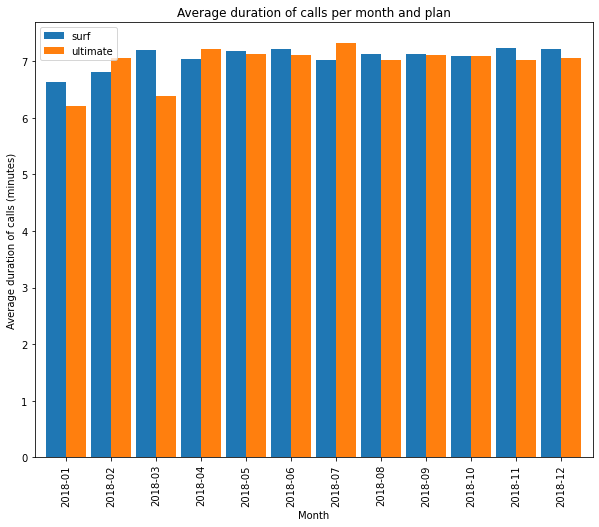

In [ ]:
# Compare average duration of calls per each plan per each distinct month
avg_duration = calls['duration'].mean()
merged_df = df.merge(calls, on=['user_id', 'month'], how='outer')
call_duration = merged_df.groupby(['month', 'plan', 'user_id'])['duration'].mean().reset_index()
avg_call_duration = call_duration.groupby(['month', 'plan'])['duration'].mean().reset_index()
print(avg_call_duration)

df_pivot = avg_call_duration.pivot(index='month', columns='plan', values='duration')
ax = df_pivot.plot(kind='bar', figsize=(10,8), width= 0.9)
ax.set_title('Average duration of calls per month and plan')
ax.set_xlabel('Month')
ax.set_ylabel('Average duration of calls (minutes)')
plt.legend()
plt.show()

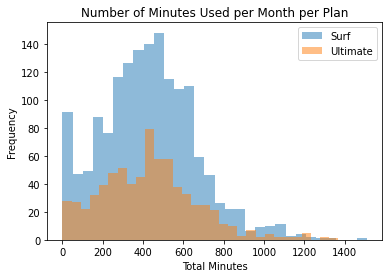

In [ ]:
# Compare the number of minutes users of each plan require each month
internet.rename(columns={'session_month': 'month'}, inplace=True)

merged_df = df.merge(calls, on=['user_id', 'month'], how='outer')
calls_per_month_duration = merged_df.groupby(['month', 'plan', 'user_id'])['duration'].sum().reset_index()
surf_calls = calls_per_month_duration[calls_per_month_duration ['plan'] == 'surf']
ultimate_calls = calls_per_month_duration[calls_per_month_duration['plan'] == 'ultimate']
surf_minutes = surf_calls['duration']
ultimate_minutes = ultimate_calls['duration']
plt.hist(surf_minutes, bins=30, alpha=.5, label='Surf')
plt.hist(ultimate_minutes, bins=30, alpha=.5, label='Ultimate')
plt.title('Number of Minutes Used per Month per Plan')
plt.xlabel('Total Minutes')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Calculate the mean and the variance of the monthly call duration
surf_mean = merged_df[merged_df['plan'] == 'surf']['duration'].mean()
surf_var = merged_df[merged_df['plan']=='surf']['duration'].var()

ultimate_mean = merged_df[merged_df['plan']=='ultimate']['duration'].mean()
ultimate_var = merged_df[merged_df['plan']=='ultimate']['duration'].var()

pivot_table = merged_df.pivot_table(index= 'plan', values= 'duration', aggfunc= ['mean', 'var','std', 'median'])
print(pivot_table)
print()

print('Mean call duration for Surf plan:', surf_mean)
print('Variance of call duration for Surf plan:', surf_var)
print('Mean call duration for Ultimate plan:', ultimate_mean)
print('Variance of call duration for Ultimate plan:', ultimate_var)


              mean        var       std   median
          duration   duration  duration duration
plan                                            
surf      7.168307  35.502268  5.958378      7.0
ultimate  7.100044  35.332282  5.944096      6.0

Mean call duration for Surf plan: 7.168307044768505
Variance of call duration for Surf plan: 35.50226776299748
Mean call duration for Ultimate plan: 7.100043527066963
Variance of call duration for Ultimate plan: 35.332282014142


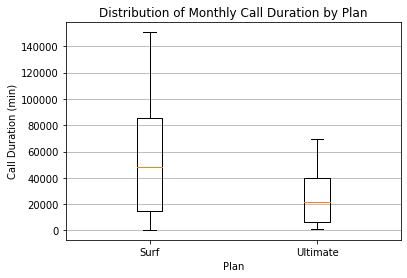

In [ ]:
# Plot a boxplot to visualize the distribution of the monthly call duration
surf_calls_duration = merged_df[merged_df['plan'] == 'surf'].groupby('month')['duration'].sum()
ultimate_calls_duration = merged_df[merged_df['plan'] == 'ultimate'].groupby('month')['duration'].sum()

plt.boxplot([surf_calls_duration, ultimate_calls_duration], labels=['Surf', 'Ultimate'])
plt.title('Distribution of Monthly Call Duration by Plan')
plt.xlabel('Plan')
plt.ylabel('Call Duration (min)')
plt.grid(axis='y')
plt.show()

In terms of calling, a boxplot for the distrubution of monthly call duration by plan shows that the Surf plan has a higher median than the Utlimate plan. It also has a larger range in call duration. The mean and varience of the Surf plan are also higher but in general they are similar. Looking at the median gives a better idea to see the duration of the Surf plan calls that exceed the Ultimate. 

### Messages

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


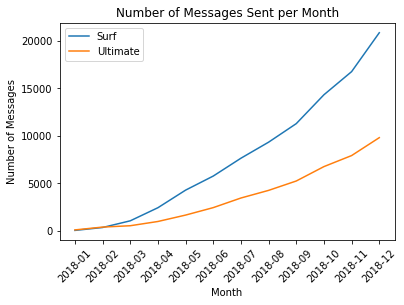

In [ ]:
# Compare the number of messages users of each plan tend to send each month
messages_by_month = merged_df.groupby(['month', 'plan'])['messages_count'].count().reset_index()
surf_messages = messages_by_month[messages_by_month['plan'] == 'surf']
ultimate_messages = messages_by_month[messages_by_month['plan'] == 'ultimate']
surf_messages.loc[:, 'month'] = surf_messages['month'].astype(str)
ultimate_messages.loc[:, 'month'] = ultimate_messages['month'].astype(str)

plt.plot(surf_messages['month'], surf_messages['messages_count'], label='Surf')
plt.plot(ultimate_messages['month'], ultimate_messages['messages_count'], label='Ultimate')

plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.title("Number of Messages Sent per Month")
plt.xticks(rotation='45')
plt.legend()
plt.show()


In [ ]:
merged_df.columns

Index(['user_id', 'month', 'calls_made', 'minutes_spent_x', 'minutes_spent_y',
       'messages_count', 'rounded_mb', 'plan', 'rounded_total_mb',
       'monthly_revenue', 'call_id', 'call_date', 'duration'],
      dtype='object')

In [ ]:
# Compare the amount of internet traffic consumed by users per plan
internet_traffic = internet.groupby(['user_id', 'month'])['mb_used_x'].sum().reset_index()
internet_traffic = internet_traffic.rename(columns={'mb_used_x': 'mb_used_per_month'})
internet_traffic = internet_traffic.rename(columns={'session_month': 'month'})
merged_df = merged_df.rename(columns={'mb_used_per_month': 'mb_used_per_month'})

merged_df = df.merge(internet_traffic, on=['user_id', 'month'], how='outer')
print(merged_df.head())

surf_traffic = merged_df[merged_df['plan'] == 'surf']['mb_used_per_month']
ultimate_traffic = merged_df[merged_df['plan'] == 'ultimate']['mb_used_per_month']


   user_id    month  calls_made  minutes_spent_x  minutes_spent_y  \
0     1000  2018-12        16.0            124.0            124.0   
1     1001  2018-08        27.0            182.0            182.0   
2     1001  2018-09        49.0            315.0            315.0   
3     1001  2018-10        65.0            393.0            393.0   
4     1001  2018-11        64.0            426.0            426.0   

   messages_count  rounded_mb      plan  rounded_total_mb  monthly_revenue  \
0            11.0     9507.35  ultimate              9508        70.000000   
1            30.0   172978.75      surf            172979      1559.248047   
2            44.0   705685.46      surf            705686      6761.464844   
3            53.0  1250507.44      surf           1250508     12082.082188   
4            36.0   943719.30      surf            943720      9086.015625   

   mb_used_per_month  
0            1901.47  
1            6919.15  
2           13314.82  
3           22330.49  
4

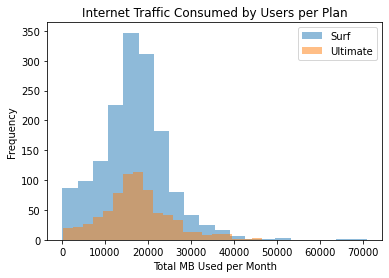

In [ ]:
plt.hist(surf_traffic, bins=20, alpha=.5, label= 'Surf')
plt.hist(ultimate_traffic, bins=20, alpha=.5, label="Ultimate")
plt.xlabel("Total MB Used per Month")
plt.ylabel('Frequency')
plt.title("Internet Traffic Consumed by Users per Plan")
plt.legend()
plt.show()


In terms of messaging, the above graphs show that their is greater frequency of internet traffic consumed by users in the Surf plan than the Ultimate plan. The number of messages sent by users per month is also greater in the Surf plan which. 

### Internet

In [ ]:
surf_mb_mean = merged_df[merged_df['plan'] == 'surf']['mb_used_per_month'].mean()
surf_var_mean = merged_df[merged_df['plan'] == 'surf']['mb_used_per_month'].var()
ultimate_mb_mean = merged_df[merged_df['plan'] == 'ultimate']['mb_used_per_month'].mean()
ultimate_mb_var = merged_df[merged_df['plan'] == 'ultimate']['mb_used_per_month'].var()
pivot_table = merged_df.pivot_table(index= 'plan', values= 'mb_used_per_month', aggfunc= ['mean', 'var','std', 'median'])
print(pivot_table)
print()
print("Mean of mb_used_per_month for Surf plan:", surf_mb_mean)
print("Variance of mb_used_per_month for Surf plan:", surf_var_mean)
print("Mean of mb_used_per_month for Ultimate plan:", ultimate_mb_mean)
print("Variance of mb_used_per_month for Ultimate plan:", ultimate_mb_var)


                      mean               var               std  \
         mb_used_per_month mb_used_per_month mb_used_per_month   
plan                                                             
surf          16717.702137      6.216823e+07       7884.682983   
ultimate      17238.642253      6.132485e+07       7831.018323   

                    median  
         mb_used_per_month  
plan                        
surf              16923.83  
ultimate          16863.45  

Mean of mb_used_per_month for Surf plan: 16717.702137355584
Variance of mb_used_per_month for Surf plan: 62168225.74692844
Mean of mb_used_per_month for Ultimate plan: 17238.642253129346
Variance of mb_used_per_month for Ultimate plan: 61324847.980956204


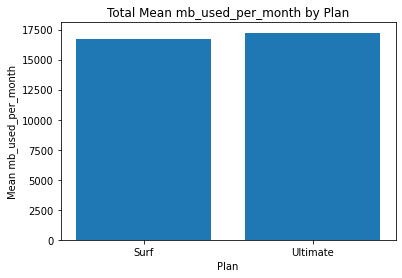

In [ ]:
surf_mean = merged_df[merged_df['plan'] == 'surf']['mb_used_per_month'].mean()
ultimate_mean = merged_df[merged_df['plan'] == 'ultimate']['mb_used_per_month'].mean()

fig, ax = plt.subplots()
ax.bar(['Surf', 'Ultimate'], [surf_mean, ultimate_mean])
ax.set_xlabel('Plan')
ax.set_ylabel('Mean mb_used_per_month')
ax.set_title('Total Mean mb_used_per_month by Plan')
plt.show()

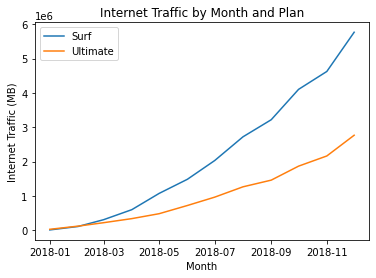

In [ ]:
surf_data = merged_df.query('plan == "surf"').groupby('month')['mb_used_per_month'].sum()
ultimate_data = merged_df.query('plan == "ultimate"').groupby('month')['mb_used_per_month'].sum()

surf_data.index = surf_data.index.to_timestamp()
ultimate_data.index = ultimate_data.index.to_timestamp()
plt.plot(surf_data.index, surf_data.values, label='Surf')
plt.plot(ultimate_data.index, ultimate_data.values, label='Ultimate')

plt.title('Internet Traffic by Month and Plan')
plt.xlabel('Month')
plt.ylabel('Internet Traffic (MB)')
plt.legend()
plt.show()


The graphs above show that internet traffic follows a similar trend as the messages per user as it is also much greater in the Surf plan. This difference in internet usage between the two plans could be due to the fact that the Surf plan includes a lower data allowance compared to the Ultimate plan. 

## Revenue

Calculating the mean and variance of monthly revenue for both the Surf and Ultimate plans, and grouping data by plan and month, we can look at the monthly revenue for each plan over time.

In [ ]:
surf_revenue_mean = merged_df[merged_df['plan'] == 'surf']['monthly_revenue'].mean()
surf_revenue_var = merged_df[merged_df['plan'] == 'surf']['monthly_revenue'].var()

ultimate_revenue_mean = merged_df[merged_df['plan'] == 'ultimate']['monthly_revenue'].mean()
ultimate_revenue_var = merged_df[merged_df['plan'] == 'ultimate']['monthly_revenue'].var()

pivot_table = merged_df.pivot_table(index= 'plan', values= 'monthly_revenue', aggfunc= ['mean', 'var','std', 'median'])
print(pivot_table)
print()
print("Mean of monthly revenue for Surf plan:", surf_revenue_mean)
print("Variance of monthly revenue for Surf plan:", surf_revenue_var)

print("Mean of monthly revenue for Ultimate plan:", ultimate_revenue_mean)
print("Variance of monthly revenue for Ultimate plan:", ultimate_revenue_var)


                    mean             var             std          median
         monthly_revenue monthly_revenue monthly_revenue monthly_revenue
plan                                                                    
surf         8595.470605    5.032887e+07     7094.284275      7781.71875
ultimate     6112.775208    2.079592e+07     4560.254887      5405.07666

Mean of monthly revenue for Surf plan: 8595.470605232835
Variance of monthly revenue for Surf plan: 50328869.377413526
Mean of monthly revenue for Ultimate plan: 6112.775207519531
Variance of monthly revenue for Ultimate plan: 20795924.634809323


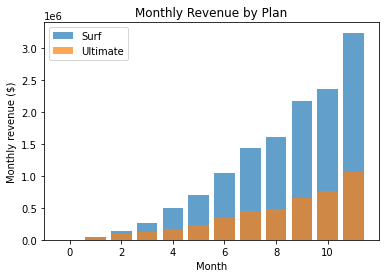

In [ ]:
revenue_by_plan = merged_df.groupby(['plan', 'month'])['monthly_revenue'].sum()

surf_revenue = revenue_by_plan['surf']
ultimate_revenue = revenue_by_plan['ultimate']

plt.bar(range(len(surf_revenue)), surf_revenue, label='Surf', alpha=0.7)
plt.bar(range(len(ultimate_revenue)), ultimate_revenue, label='Ultimate', alpha=0.7)

plt.xlabel('Month')
plt.ylabel('Monthly revenue ($)')
plt.title('Monthly Revenue by Plan')
plt.legend()
plt.show()

From the bar chart, we can see that the Surf plan consistently generates more revenue than the Ultimate plan each month. This is unexpected as the Ultimate plan has a higher monthly fee than the Surf plan. The varience of the Surf plan is greater, while the mean is lower. The revenue for both plans increases over time, which could indicate that the customer base is growing or that existing customers are using more services.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

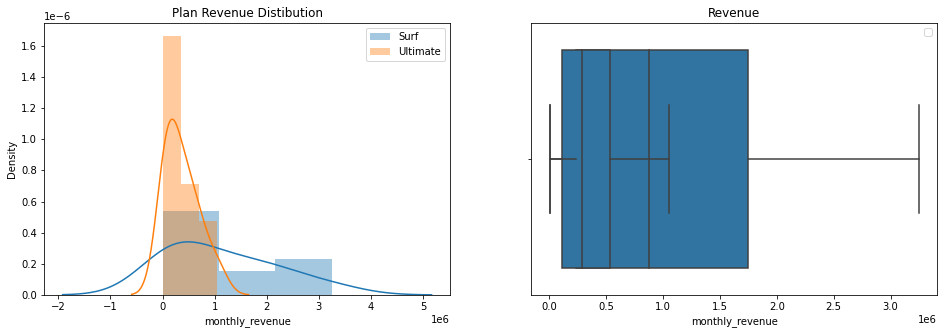

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.distplot(surf_revenue, label='Surf', ax=axes[0])
axes[0].set_title('Plan Revenue Distribution')
axes[0].legend()
sns.distplot(ultimate_revenue, label='Ultimate', ax=axes[0])
axes[0].set_title('Plan Revenue Distibution')
axes[0].legend()
sns.boxplot(surf_revenue, ax=axes[1])
sns.boxplot(ultimate_revenue, ax=axes[1])
axes[1].set_title('Revenue')
axes[1].legend()

The distribution of revenue from users of the Ultimate and Surf calling plans are different, with the Surf plan generating less revenue. 

## Test Statistical Hypotheses

In comparing the means of two independents, a two-sample t-test can be used to test the hypothesis. An alpha value of 0.05, is appropriate, as it is commonly used as a 5% significance in hypothesis testing.

**H0 (null hypothesis):** The average revenue from users of the Ultimate and Surf calling plans is equal and does not differ.

**H1 (alternative hypothesis):** The average revenue from users of the Ultimate and Surf calling plans differs significantly.

In [ ]:
# Test the hypotheses
surf_revenue= merged_df[merged_df['plan']=='surf']['monthly_revenue']
ultimate_revenue = merged_df[merged_df['plan']=='ultimate']['monthly_revenue']
alpha = 0.05 
stat, p = ttest_ind(surf_revenue, ultimate_revenue)
print('t-statistic:', stat)
print('p-value:', p)

if p < alpha:
    print('We reject the null hypothesis: the average revenue from users of the Ultimate and Surf calling plans differs.')
else:
    print('We fail to reject the null hypothesis: the average revenue from users of the Ultimate and Surf calling plans does not differ significantly.')

t-statistic: 8.610744827912498
p-value: 1.3267199161762782e-17
We reject the null hypothesis: the average revenue from users of the Ultimate and Surf calling plans differs.


The distribution of revenue from users of the Ultimate and Surf calling plans are different, with the Surf plan generating less revenue. 

**H0 (null hypothesis):** The average revenue from users in the NY-NJ area is not significantly different from the average revenue of users from other regions.

**H1 (alternative hypothesis):** The average revenue from users in the NY-NJ area is significantly different from the average revenue of users from other regions.

In [ ]:
merged_df = pd.merge(df, users[['user_id', 'state']], on='user_id')

merged_df.columns

Index(['user_id', 'month', 'calls_made', 'minutes_spent_x', 'minutes_spent_y',
       'messages_count', 'rounded_mb', 'plan', 'rounded_total_mb',
       'monthly_revenue', 'state'],
      dtype='object')

In [ ]:
# Test the hypotheses
from scipy.stats import levene
ny_nj_revenue = merged_df.loc[merged_df['state'].isin(['NY MSA', 'NJ MSA']), 'monthly_revenue']
other_revenue = merged_df.loc[~merged_df['state'].isin(['NY MSA', 'NJ MSA']), 'monthly_revenue']
print(ny_nj_revenue)

stat, p_value = levene(ny_nj_revenue, other_revenue)
print('t-statistic:', stat)
print('p-value:', p)

stat, p = ttest_ind(ny_nj_revenue, other_revenue)
print('t-statistic:', stat)
print('p-value:', p)

if p_value < 0.05:
    print("We reject the null hypothesis: the average revenue from users in the NY-NJ area is different from that of the users from the other regions")
else:
    print("We fail to reject the null hypothesis: the average revenue from users in the NY-NJ area is not different from that of the users from the other regions")

355        20.000000
356     12083.746406
357     10265.271875
358      8822.215313
359      9449.408281
360      4999.295938
451      5569.795625
452     16151.583281
453     19179.230234
454     16859.177812
455     14535.199766
901      1950.273438
902      1746.764531
903      1624.287734
1369     3322.177734
1370    22902.323047
1371    14462.278281
1372     1995.888672
1719     1626.074219
1720    19454.980469
1721    15203.017578
1722     9268.004766
1723    14356.562500
1724    15522.001953
1896     1976.464844
1897     6552.988281
1898     3358.839297
1899     4137.167969
1900     3127.391484
Name: monthly_revenue, dtype: float64
t-statistic: 2.130934080356607
p-value: 1.3267199161762782e-17
t-statistic: 0.972138456883113
p-value: 0.3310842973430752
We fail to reject the null hypothesis: the average revenue from users in the NY-NJ area is not different from that of the users from the other regions


The average revenue from users in the NY-NJ area is not significantly different from that of users from other regions.


## General conclusion

After analyzing the dataset provided by Megaline, several important conclusions can be made:

The Surf plan is more popular among users, but the Ultimate plan has higher revenue per user on average. Most users do not exceed their monthly limit for calls and messages, but many users exceed their monthly limit for internet usage.

The average revenue from users of the Ultimate and Surf calling plans differs significantly, with the Surf plan generating less revenue per user on average. Users of both plans tend to increase their usage of services over time, with the most usage in December.

Based on these conclusions, the Megaline may consider targeting marketing efforts towards the Ultimate plan in order to increase revenue per user, or creating additional plans for frequent users who exceed plan limitations.